![image](images\YAH.png)

In [540]:
import random, math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=16,5

def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    p = np.exp(x - np.max(x))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z)
    else:
        if act=="sigmoid":
            return activated_value * (1 - activated_value)
        elif act == "swish":
            return activated_value + sigmoid(z) * (1 - activated_value)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return softmax(z)
    
    

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, activation=None, last_activation=None):
        new_layer = Layer(input_size, output_size, activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data):
        self.layers[0].forward_pass(input_data)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].Y[-1]
            self.layers[i].forward_pass(prev_layer_out)
            
        return self.layers[-1].Y[-1]
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps):
        gradient, loss = self.layers[-1].der_MSE(target)
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].Y
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps)
        return loss
            
class Layer():
    
    def __init__(self, input_size, output_size, activation=None, last_activation=None):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.last_activation = last_activation
        
        self.weights_X = self.weights_init(output_size, input_size)
        self.weights_H = self.weights_init(output_size, output_size)
        self.weights_Y = self.weights_init(output_size, output_size)
        self.bias      = self.weights_init(output_size, 1)
        
        self.A = np.empty((0,output_size,1))
        self.Y = np.empty((0,output_size,1))
        self.H = np.empty((0,output_size,1))
        
        
    def weights_init(self, rows, cols):
        return np.random.uniform(-1,1,(rows, cols))
    
    
    def forward_pass(self, input_data):
        new_H = self.weights_X.dot(input_data) + self.bias
        if len(self.A) > 0:
             new_H += self.weights_H.dot(self.A[-1]) 
        self.H = np.append(self.H, np.array([new_H]), axis=0)
        
        
        new_A = activation_function(self.H[-1], self.activation)
        self.A = np.append(self.A, np.array([new_A]), axis=0)
        
        
        new_Y = self.weights_Y.dot(self.A[-1])
        if self.last_activation != None:
            new_Y = activation_function(new_Y, self.last_activation)
        self.Y = np.append(self.Y, np.array([new_Y]), axis=0)
        

    def clear_memory(self):
        self.A = np.empty((0, self.output_size, 1))
        self.Y = np.empty((0, self.output_size, 1))
        self.H = np.empty((0, self.output_size, 1))
        
        
    def der_MSE(self, target):
        return 2*(self.Y[-1] - target), np.power(target - self.Y[-1], 2)
     
    
    def descent(self, gradient, input_data, learning_rate, max_steps):
        input_matrix = np.array(input_data)
        
        
        
        dC_Wh = 0
        dC_Wx = 0
        dC_B = 0
        
        dY_Wy = np.tile(self.A[-1].T, (self.weights_Y.shape[0], 1))
        dC_Wy = np.multiply(np.tile(gradient, (1, self.weights_Y.shape[1])), dY_Wy)
        
        dY_A = np.sum(self.weights_Y, axis=0, keepdims=True).T
        dC_A = np.multiply(gradient, dY_A)
        dA_H = activation_function(self.H[-1], self.activation, derivative=True, activated_value=self.A[-1])
        dC_H = np.multiply(gradient, dA_H)
        dC_H_transformed_forX = np.tile(dC_H, (1, self.weights_X.shape[1]))
        dC_X = np.sum(np.multiply(self.weights_X, dC_H_transformed_forX), axis=0, keepdims=True).T
        
        
        dA_Wh = np.empty(self.A[-1].shape)
        dA_Wh.fill(1)
        for i in range(0, min(len(self.A), max_steps)):
            dA_Wh = np.multiply(dA_Wh, activation_function(self.H[i], self.activation, derivative=True, activated_value=self.A[i]))
            if i == min(len(self.A), max_steps)-1:
                break
            dA_Wh = np.multiply(dA_Wh, np.sum(self.weights_H, axis=0, keepdims=True).T)
            dA_Wh += self.A[i]
        dC_Wh = np.multiply(dA_Wh, dC_A)
        dC_Wh = np.tile(dC_Wh, (1, self.weights_H.shape[1]))
        dC_Wh = np.clip(dC_Wh, -1.5, 1.5)
        
            
        dA_Wx = np.sum(np.tile(input_matrix[0].T, (self.weights_X.shape[0], 1)), axis=1, keepdims=True)
        for i in range(0, min(len(self.A), max_steps)):
            dA_H_temp = activation_function(self.H[i], self.activation, derivative=True, activated_value=self.A[i])
            dA_Wx = np.multiply(dA_H_temp, dA_Wx)
            if i == min(len(self.A), max_steps)-1:
                break
            dA_Wx = np.multiply(np.sum(self.weights_H, axis=0, keepdims=True).T, dA_Wx)
            dA_Wx += np.sum(np.tile(input_matrix[i+1].T, (self.weights_X.shape[0], 1)), axis=1, keepdims=True)
        dC_Wx = np.multiply(dA_Wx, dC_A)
        dC_Wx = np.tile(dC_Wx, (1, self.weights_X.shape[1]))
        
        
        dA_B = np.empty(self.A[-1].shape)
        dA_B.fill(1)
        for i in range(0, min(len(self.A), max_steps)):
            dA_B = np.multiply(dA_B, activation_function(self.H[i], self.activation, derivative=True, activated_value=self.A[i]))
            if i == min(len(self.A), max_steps)-1:
                break
            dA_B = np.multiply(dA_B, np.sum(self.weights_H, axis=0, keepdims=True).T)
            dA_B += 1
        dC_B = np.multiply(dA_B, dC_A)
        
        """weights update"""
        self.weights_Y -= learning_rate * dC_Wy
        self.weights_H -= learning_rate * dC_Wh
        self.bias      -= learning_rate * dC_B
        self.weights_X -= learning_rate * dC_Wx
        
        return np.clip(dC_X, -1, 1)
    

In [541]:
network = RNN(0.001)
network.add_layer(2, 4, "tanh")
network.add_layer(4, 4, "tanh")
network.add_layer(4, 2, "sigmoid")

In [542]:
input_data = []
for i in range(1, 60):
    binary = list(bin(i%8)[2:].rjust(3, "0"))
    toAppend = []
    for j in range(1, len(binary)):
        toAppend.append([0.9 if int(binary[j]) == 1 else 0.1])
    input_data.append(toAppend)
    print(str(toAppend))
    



[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]
[[0.1], [0.1]]
[[0.1], [0.9]]
[[0.9], [0.1]]
[[0.9], [0.9]]


---------------
epoch 0
---------------
epoch 0
sample 0
output: 
[[-0.40916177]
 [ 0.38465857]]
target: 
[[0.9], [0.1]]
-----------------average loss: [[0.62950278]
 [0.38688012]]


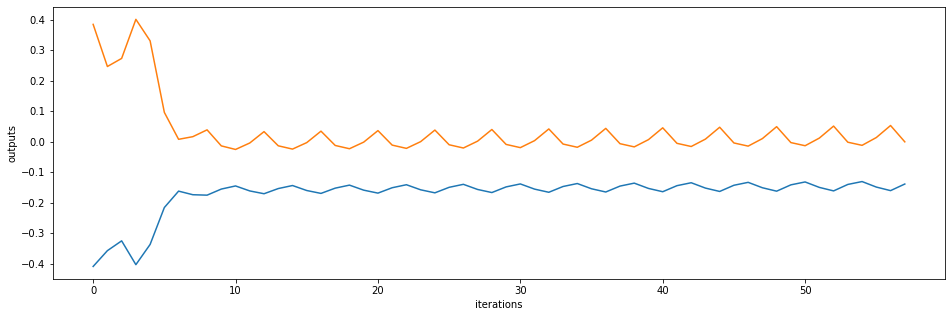

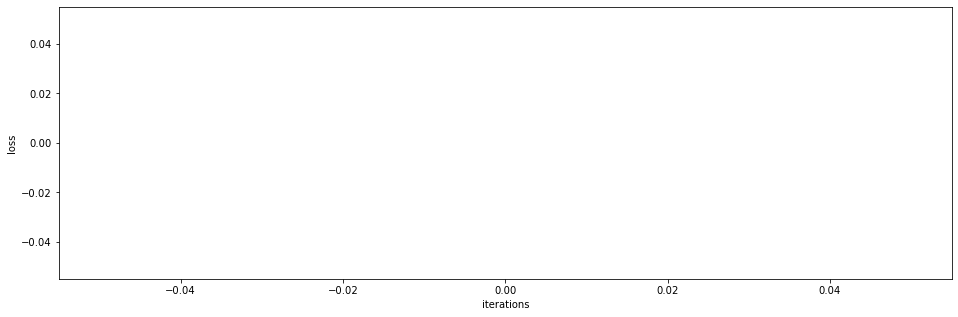

---------------
epoch 1
---------------
epoch 2
---------------
epoch 3
---------------
epoch 4
---------------
epoch 5
---------------
epoch 6
---------------
epoch 7
---------------
epoch 8
---------------
epoch 9
---------------
epoch 10
---------------
epoch 11
---------------
epoch 12
---------------
epoch 13
---------------
epoch 14
---------------
epoch 15
---------------
epoch 16
---------------
epoch 17
---------------
epoch 18
---------------
epoch 19
---------------
epoch 20
---------------
epoch 21
---------------
epoch 22
---------------
epoch 23
---------------
epoch 24
---------------
epoch 25
---------------
epoch 26
---------------
epoch 27
---------------
epoch 28
---------------
epoch 29
---------------
epoch 30
---------------
epoch 31
---------------
epoch 32
---------------
epoch 33
---------------
epoch 34
---------------
epoch 35
---------------
epoch 36
---------------
epoch 37
---------------
epoch 38
---------------
epoch 39
---------------
epoch 40
---------

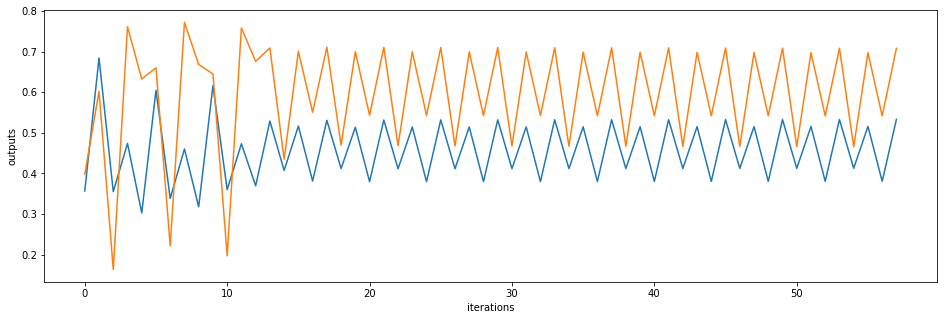

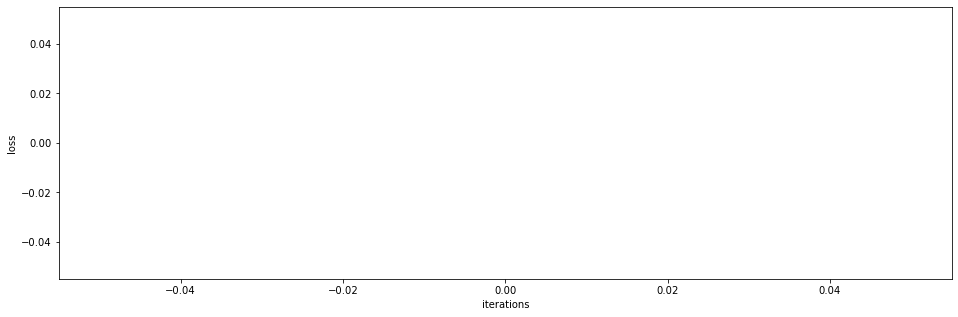

---------------
epoch 51
---------------
epoch 52
---------------
epoch 53
---------------
epoch 54
---------------
epoch 55
---------------
epoch 56
---------------
epoch 57
---------------
epoch 58
---------------
epoch 59
---------------
epoch 60
---------------
epoch 61
---------------
epoch 62
---------------
epoch 63
---------------
epoch 64
---------------
epoch 65
---------------
epoch 66
---------------
epoch 67
---------------
epoch 68
---------------
epoch 69
---------------
epoch 70
---------------
epoch 71
---------------
epoch 72
---------------
epoch 73
---------------
epoch 74
---------------
epoch 75
---------------
epoch 76
---------------
epoch 77
---------------
epoch 78
---------------
epoch 79
---------------
epoch 80
---------------
epoch 81
---------------
epoch 82
---------------
epoch 83
---------------
epoch 84
---------------
epoch 85
---------------
epoch 86
---------------
epoch 87
---------------
epoch 88
---------------
epoch 89
---------------
epoch 90


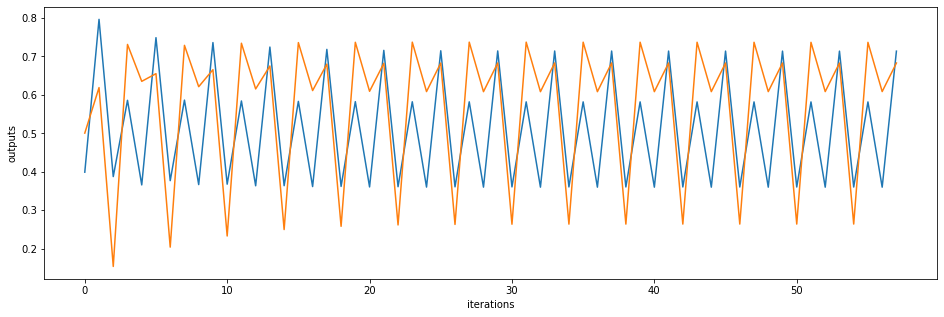

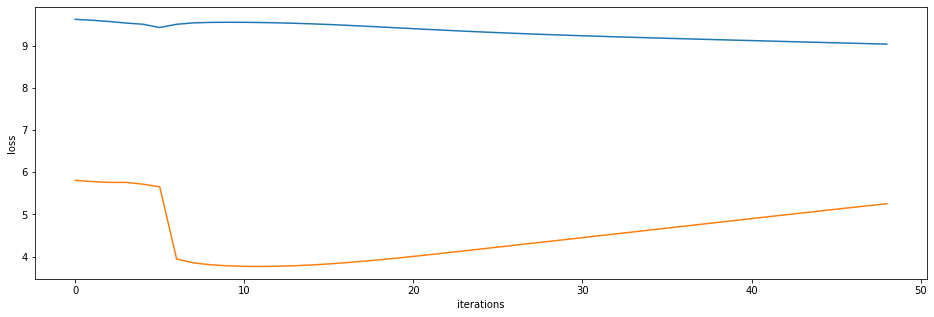

---------------
epoch 101
---------------
epoch 102
---------------
epoch 103
---------------
epoch 104
---------------
epoch 105
---------------
epoch 106
---------------
epoch 107
---------------
epoch 108
---------------
epoch 109
---------------
epoch 110
---------------
epoch 111
---------------
epoch 112
---------------
epoch 113
---------------
epoch 114
---------------
epoch 115
---------------
epoch 116
---------------
epoch 117
---------------
epoch 118
---------------
epoch 119
---------------
epoch 120
---------------
epoch 121
---------------
epoch 122
---------------
epoch 123
---------------
epoch 124
---------------
epoch 125
---------------
epoch 126
---------------
epoch 127
---------------
epoch 128
---------------
epoch 129
---------------
epoch 130
---------------
epoch 131
---------------
epoch 132
---------------
epoch 133
---------------
epoch 134
---------------
epoch 135
---------------
epoch 136
---------------
epoch 137
---------------
epoch 138
------------

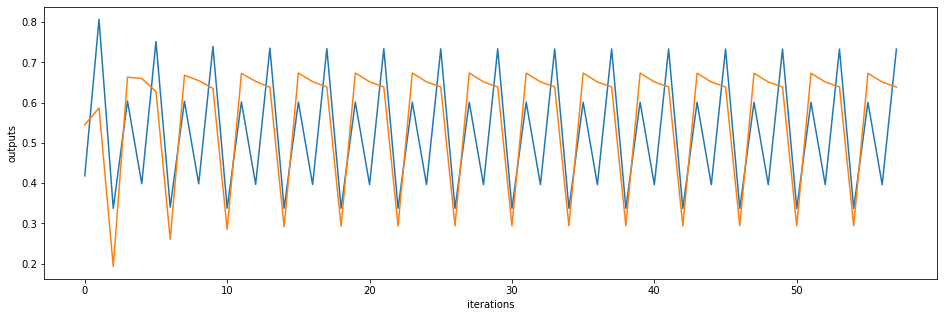

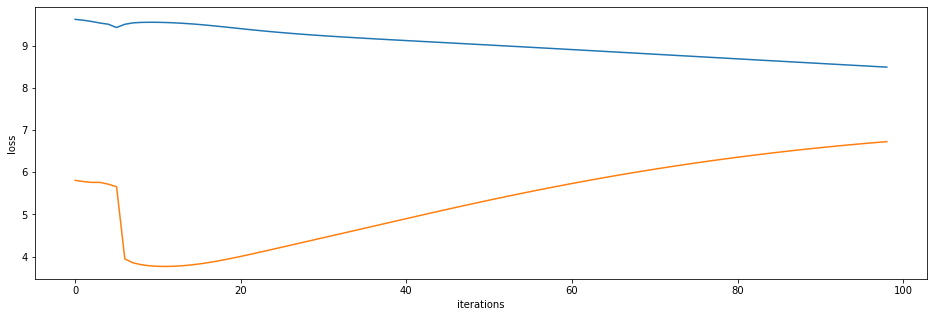

---------------
epoch 151
---------------
epoch 152
---------------
epoch 153
---------------
epoch 154
---------------
epoch 155
---------------
epoch 156
---------------
epoch 157
---------------
epoch 158
---------------
epoch 159
---------------
epoch 160
---------------
epoch 161
---------------
epoch 162
---------------
epoch 163
---------------
epoch 164
---------------
epoch 165
---------------
epoch 166
---------------
epoch 167
---------------
epoch 168
---------------
epoch 169
---------------
epoch 170
---------------
epoch 171
---------------
epoch 172
---------------
epoch 173
---------------
epoch 174
---------------
epoch 175
---------------
epoch 176
---------------
epoch 177
---------------
epoch 178
---------------
epoch 179
---------------
epoch 180
---------------
epoch 181
---------------
epoch 182
---------------
epoch 183
---------------
epoch 184
---------------
epoch 185
---------------
epoch 186
---------------
epoch 187
---------------
epoch 188
------------

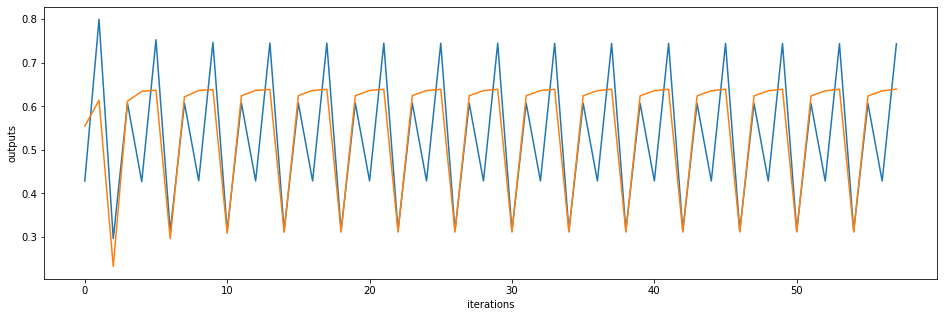

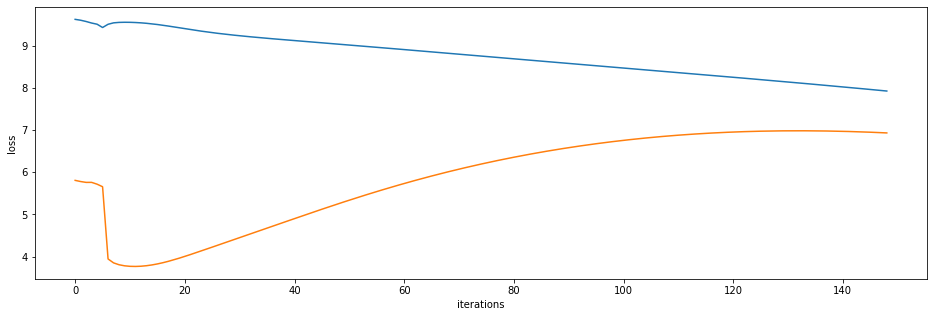

---------------
epoch 201
---------------
epoch 202
---------------
epoch 203
---------------
epoch 204
---------------
epoch 205
---------------
epoch 206
---------------
epoch 207
---------------
epoch 208
---------------
epoch 209
---------------
epoch 210
---------------
epoch 211
---------------
epoch 212
---------------
epoch 213
---------------
epoch 214
---------------
epoch 215
---------------
epoch 216
---------------
epoch 217
---------------
epoch 218
---------------
epoch 219
---------------
epoch 220
---------------
epoch 221
---------------
epoch 222
---------------
epoch 223
---------------
epoch 224
---------------
epoch 225
---------------
epoch 226
---------------
epoch 227
---------------
epoch 228
---------------
epoch 229
---------------
epoch 230
---------------
epoch 231
---------------
epoch 232
---------------
epoch 233
---------------
epoch 234
---------------
epoch 235
---------------
epoch 236
---------------
epoch 237
---------------
epoch 238
------------

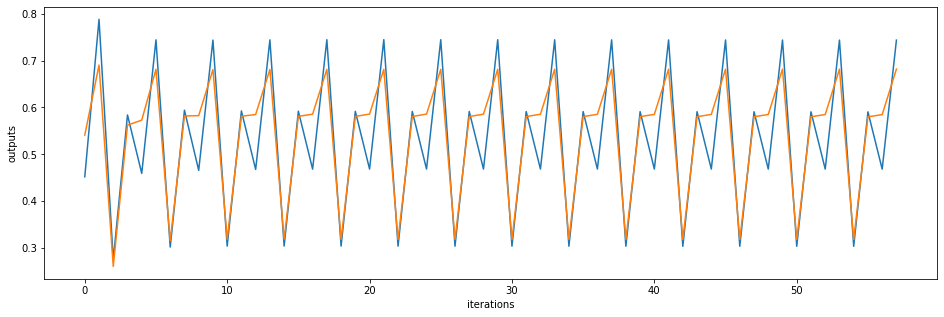

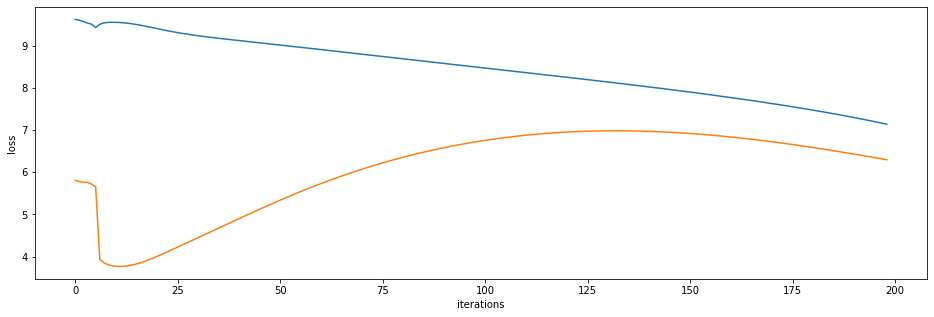

---------------
epoch 251
---------------
epoch 252
---------------
epoch 253
---------------
epoch 254
---------------
epoch 255
---------------
epoch 256
---------------
epoch 257
---------------
epoch 258
---------------
epoch 259
---------------
epoch 260
---------------
epoch 261
---------------
epoch 262
---------------
epoch 263
---------------
epoch 264
---------------
epoch 265
---------------
epoch 266
---------------
epoch 267
---------------
epoch 268
---------------
epoch 269
---------------
epoch 270
---------------
epoch 271
---------------
epoch 272
---------------
epoch 273
---------------
epoch 274
---------------
epoch 275
---------------
epoch 276
---------------
epoch 277
---------------
epoch 278
---------------
epoch 279
---------------
epoch 280
---------------
epoch 281
---------------
epoch 282
---------------
epoch 283
---------------
epoch 284
---------------
epoch 285
---------------
epoch 286
---------------
epoch 287
---------------
epoch 288
------------

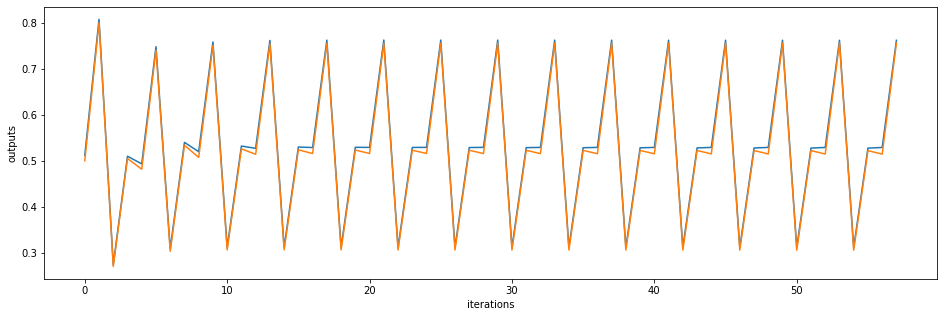

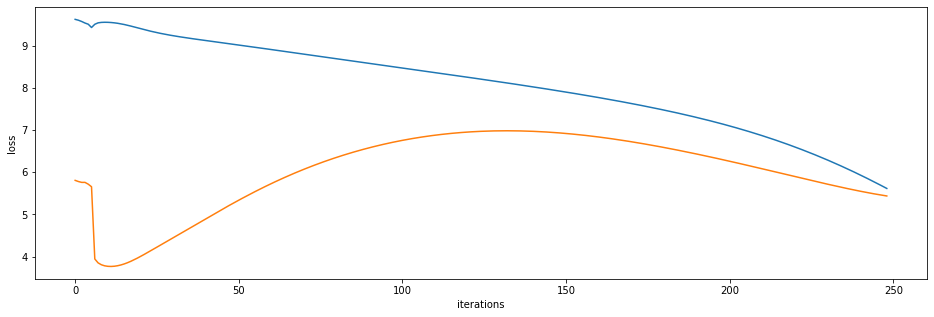

---------------
epoch 301
---------------
epoch 302
---------------
epoch 303
---------------
epoch 304
---------------
epoch 305
---------------
epoch 306
---------------
epoch 307
---------------
epoch 308
---------------
epoch 309
---------------
epoch 310
---------------
epoch 311
---------------
epoch 312
---------------
epoch 313
---------------
epoch 314
---------------
epoch 315
---------------
epoch 316
---------------
epoch 317
---------------
epoch 318
---------------
epoch 319
---------------
epoch 320
---------------
epoch 321
---------------
epoch 322
---------------
epoch 323
---------------
epoch 324
---------------
epoch 325
---------------
epoch 326
---------------
epoch 327
---------------
epoch 328
---------------
epoch 329
---------------
epoch 330
---------------
epoch 331
---------------
epoch 332
---------------
epoch 333
---------------
epoch 334
---------------
epoch 335
---------------
epoch 336
---------------
epoch 337
---------------
epoch 338
------------

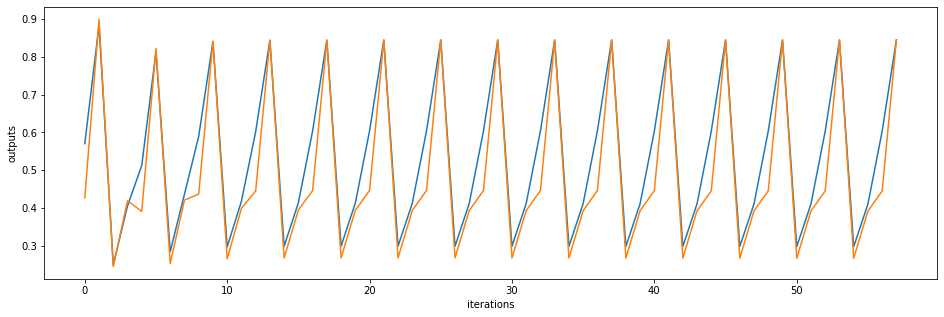

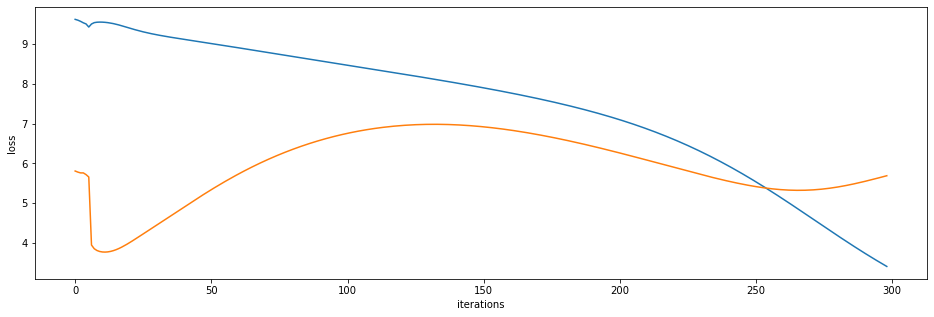

---------------
epoch 351
---------------
epoch 352
---------------
epoch 353
---------------
epoch 354
---------------
epoch 355
---------------
epoch 356
---------------
epoch 357
---------------
epoch 358
---------------
epoch 359
---------------
epoch 360
---------------
epoch 361
---------------
epoch 362
---------------
epoch 363
---------------
epoch 364
---------------
epoch 365
---------------
epoch 366
---------------
epoch 367
---------------
epoch 368
---------------
epoch 369
---------------
epoch 370
---------------
epoch 371
---------------
epoch 372
---------------
epoch 373
---------------
epoch 374
---------------
epoch 375
---------------
epoch 376
---------------
epoch 377
---------------
epoch 378
---------------
epoch 379
---------------
epoch 380
---------------
epoch 381
---------------
epoch 382
---------------
epoch 383
---------------
epoch 384
---------------
epoch 385
---------------
epoch 386
---------------
epoch 387
---------------
epoch 388
------------

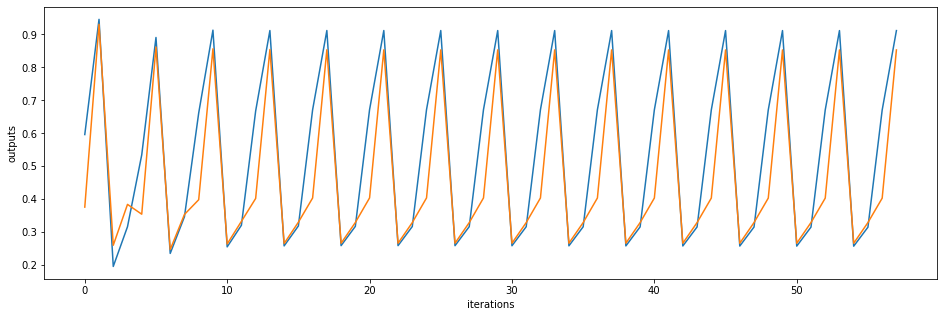

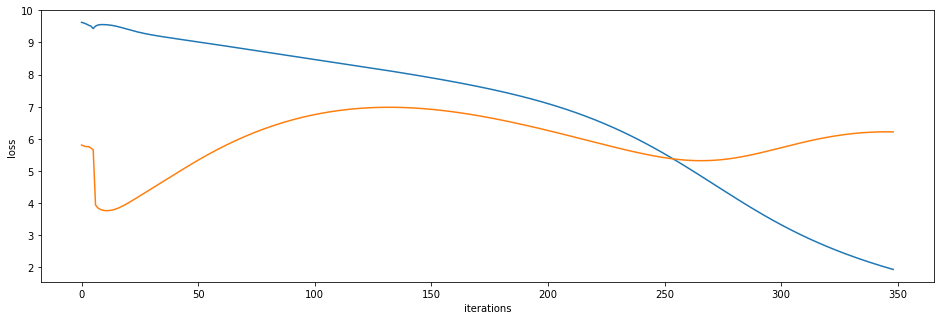

---------------
epoch 401
---------------
epoch 402
---------------
epoch 403
---------------
epoch 404
---------------
epoch 405
---------------
epoch 406
---------------
epoch 407
---------------
epoch 408
---------------
epoch 409


In [ ]:
epochs = 9000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    print("---------------")
    print("epoch " + str(e))
        
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 8)
  
        if e%50 == 0 and i%111 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%50 == 0:        
        print("-----------------average loss: " + str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.show()
        
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.show()
        
        
    prevLoss = loss
    if e > 50:
        losses.append(loss)
    
    
    
print("------------training finished successfully!------------")
        